# Deep learning meets missing data: Doing it MIWAE


In this notebook, we'll show how to learn a deep generative model on a small and **incomplete** continuous data set. We will also show how to **impute** the missing values of this data set. 

This is based on the following paper, available [on arXiv](https://arxiv.org/abs/1812.02633):

P.-A. Mattei & J. Frellsen, **MIWAE: Deep Generative Modelling and Imputation of Incomplete Data Sets**, *Proceedings of the 36th International Conference on Machine Learning*, PMLR 97:4413-4423, 2019.

It is possible to run this notebook in Google Colab, which allows to benefit from free GPU computing.
<table class="tfo-notebook-buttons" align="left">
    <td>
    <a target="_blank" href="https://colab.research.google.com/github/pamattei/MIWAE_demo_UCI.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


# Installing and loading useful stuff

In [1]:
!pip3 install --user --upgrade scikit-learn # We need to update it to run missForest
import tensorflow as tf
import numpy as np
import scipy.stats
import scipy.io
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import tensorflow_probability as tfp
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn import preprocessing
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.2)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
def mse(xhat,xtrue,mask): # MSE function for imputations
    xhat = np.array(xhat)
    xtrue = np.array(xtrue)
    return np.mean(np.power(xhat-xtrue,2)[~mask])

# Loading the data

We'll use the Boston data set from scikit-learn:



In [0]:
from sklearn.datasets import load_boston
data = load_boston(True)[0]

It is also possible to use the Iris or the Breast cancer data sets by uncommenting one of the following cells:

In [0]:
#from sklearn.datasets import load_iris
#data = load_iris(True)[0]

In [0]:
#from sklearn.datasets import load_breast_cancer
#data = load_breast_cancer(True)[0]

It is also possible to use the "white wine", "red wine", or "banknote" UCI data sets by uncommenting one of the following cells:



In [0]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
#data = np.array(pd.read_csv(url, low_memory=False, sep=';'))

In [0]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
#data = np.array(pd.read_csv(url, low_memory=False, sep=';'))

In [0]:
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
#data = np.array(pd.read_csv(url, low_memory=False, sep=','))[:,0:4]

We now standardise the data:

In [0]:
xfull = (data - np.mean(data,0))/np.std(data,0)
n = xfull.shape[0] # number of observations
p = xfull.shape[1] # number of features

We will remove uniformy at random 50% of the data. This corresponds to a *missing completely at random (MCAR)* scenario.

In [0]:
np.random.seed(1234)
tf.set_random_seed(1234)

perc_miss = 0.5 # 50% of missing data
xmiss = np.copy(xfull)
xmiss_flat = xmiss.flatten()
miss_pattern = np.random.choice(n*p, np.floor(n*p*perc_miss).astype(np.int), replace=False)
xmiss_flat[miss_pattern] = np.nan 
xmiss = xmiss_flat.reshape([n,p]) # in xmiss, the missing values are represented by nans
mask = np.isfinite(xmiss) # binary mask that indicates which values are missing

A simple way of imputing the incomplete data is to replace the missing values by zeros. This x_hat0 is what will be fed to our encoder.

In [0]:
xhat_0 = np.copy(xmiss)
xhat_0[np.isnan(xmiss)] = 0

# Placeholders and hyperparemeters

In [0]:
x = tf.placeholder(tf.float32, shape=[None, p]) # Placeholder for xhat_0
learning_rate = tf.placeholder(tf.float32, shape=[])
batch_size = tf.shape(x)[0]
xmask = tf.placeholder(tf.bool, shape=[None, p])
K= tf.placeholder(tf.int32, shape=[]) # Placeholder for the number of importance weights

# Model building

We will use a **deep latent variable model with a Gaussian prior and a Student's t observation model**. This can be written:

$$p(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p(\mathbf{x}_i|\mathbf{z}_i) = \text{St} (\mathbf{x}_i|\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}_i),\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\mu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}^p$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$ are functions parametrised by deep neural nets.

The weights of these nets are stored in a parameter $\boldsymbol{\theta}$. We choose to use the following simple architecture, where the 3 neural nets share the first layers:
$$f_{\boldsymbol{\theta}} (\mathbf{z})=\sigma(\mathbf{W}_1\sigma(\mathbf{W}_0\mathbf{z}+\mathbf{b}_0)+\mathbf{b}_1) $$

$$\boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}) = \mathbf{W}_\boldsymbol{\mu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\mu}, $$

$$\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Diag}\left(\text{Softplus}(\mathbf{W}_\boldsymbol{\sigma}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\sigma}) + 10^{-3}\right), $$

$$\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z}) = \text{Softplus}(\mathbf{W}_\boldsymbol{\nu}f_{\boldsymbol{\theta}} (\mathbf{z})+\mathbf{b}_\boldsymbol{\nu}) + 3. $$

A few **non-essential remarks** about this architecture:

* This parametrisation is quite close to the one we use in the MIWAE paper. The main difference is that we use $\sigma = \text{ReLU}$ (which leads to faster training) while we used $\sigma = \text{tanh}$ in the paper.
*   We use a [location-scale parametrisation](https://en.wikipedia.org/wiki/Location%E2%80%93scale_family) of the t distribution, following [the parametrisation available in TensorFlow](https://www.tensorflow.org/api_docs/python/tf/distributions/StudentT). Note in particular that $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}(\mathbf{z})$ is not the covariance matrix of $\mathbf{x} | \mathbf{z}$. When it exitsts, the actual covariance matrix is diagonal with diagonal  $$ \frac{\text{diag}(\boldsymbol{\Sigma}_{\boldsymbol{\theta}} (\mathbf{z}))^2 \boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})}{\boldsymbol{\nu}_{\boldsymbol{\theta}}(\mathbf{z})-2}$$ (where all operations are made entrywise).
*   The fact that the covariance matrix is diagonal means that we assume that **the features are independent conditionnally on the latent variable** (which is customary for DLVMs).
* We add $3$ to the neural net that outputs the degrees of freedom. This is to guarantee that the tails of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are not too heavy. Indeed, having too heavy tails might imply that the mean of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ does not exist! Adding 3 implies that the degrees of freedom is always larger than 3, implying in turn that **at least the first 3 moments of $p_{\boldsymbol{\theta}}(\mathbf{x} | \mathbf{z})$ are well-defined.**
* We add $10^{-3}$ to the diagonal entries of $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}$ to prevent singularities, [as advocated in our NeurIPS 2018 paper](https://papers.nips.cc/paper/7642-leveraging-the-exact-likelihood-of-deep-latent-variable-models). Why $10^{-3}$ specifically? Because, since the data have unit variance, this will imply that the latent variable explains at most $99.9999\%$ of the variance of the data, which does not seem too restrictive. **This choice might be poor if the data are not standardised.**




We begin with the prior:

In [0]:
d = np.floor(p/2).astype(int) # dimension of the latent space

p_z = tfd.MultivariateNormalDiag(loc=tf.zeros(d, tf.float32))

 Now, we define the **decoder**, which will be the backbone of the three functions $\boldsymbol{\mu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}^p$, $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$. Here, the output space of this decoder is $\mathbb{R}^{3p}$. Some additional operations are needed for $\boldsymbol{\Sigma}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathcal{S}_p^{++}$, and $\boldsymbol{\nu}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{R}_+^p$, but it'll be more convenient to implement them later.

In [14]:
h = 128 # number of hidden units (same for all MLPs)

sigma = "relu"

decoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[d,]),
  tfkl.Dense(h, activation=sigma,kernel_initializer="orthogonal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="orthogonal"),
  tfkl.Dense(3*p,kernel_initializer="orthogonal") # the decoder will output both the mean, the scale, and the number of degrees of freedoms (hence the 3*p)
])

Instructions for updating:
Colocations handled automatically by placer.


#Building the inference network (*aka* encoder)

We will build a Student's t posterior approximation by using an **encoder** that mimicks the architecture of the decoder.


The imputation function $\iota$ replaces the missing values by learned constants. Note that this is slightly more general than what we use in the paper (which was just replacing missing values by zeros).

In [0]:
tiledmask = tf.tile(xmask,[K,1])
tiledmask_float = tf.cast(tiledmask,tf.float32)
mask_not_float = tf.abs(-tf.cast(xmask,tf.float32))

iota = tf.Variable(np.zeros([1,p]),dtype=tf.float32)
tilediota = tf.tile(iota,[batch_size,1])
iotax = x + tf.multiply(tilediota,mask_not_float)

In [0]:
encoder = tfk.Sequential([
  tfkl.InputLayer(input_shape=[p,]),
  tfkl.Dense(h, activation=sigma,kernel_initializer="orthogonal"),
  tfkl.Dense(h, activation=sigma,kernel_initializer="orthogonal"),
  tfkl.Dense(3*d,kernel_initializer="orthogonal")
])

#Building the MIWAE bound

We define the MIWAE bound:

$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}^\text{o}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i^\text{o}|\mathbf{z}_{ik})p(\mathbf{z}_{ik})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}^\text{o}_i)} \right].
$$

In [0]:
out_encoder = encoder(iotax)
q_zgivenxobs = tfd.Independent(distribution=tfd.StudentT(loc=out_encoder[..., :d], scale=tf.nn.softplus(out_encoder[..., d:(2*d)]), df=3 + tf.nn.softplus(out_encoder[..., (2*d):(3*d)])))
zgivenx = q_zgivenxobs.sample(K)
zgivenx_flat = tf.reshape(zgivenx,[K*batch_size,d])
data_flat = tf.reshape(tf.tile(x,[K,1]),[-1,1])

In [0]:
out_decoder = decoder(zgivenx_flat)
all_means_obs_model = out_decoder[..., :p]
all_scales_obs_model = tf.nn.softplus(out_decoder[..., p:(2*p)]) + 0.001
all_degfreedom_obs_model = tf.nn.softplus(out_decoder[..., (2*p):(3*p)]) + 3
all_log_pxgivenz_flat = tfd.StudentT(loc=tf.reshape(all_means_obs_model,[-1,1]),scale=tf.reshape(all_scales_obs_model,[-1,1]),df=tf.reshape(all_degfreedom_obs_model,[-1,1])).log_prob(data_flat)
all_log_pxgivenz = tf.reshape(all_log_pxgivenz_flat,[K*batch_size,p])

In [0]:
logpxobsgivenz = tf.reshape(tf.reduce_sum(tf.multiply(all_log_pxgivenz,tiledmask_float),1),[K,batch_size])
logpz = p_z.log_prob(zgivenx)
logq = q_zgivenxobs.log_prob(zgivenx)

In [20]:
miwae_loss = -tf.reduce_mean(tf.reduce_logsumexp(logpxobsgivenz + logpz - logq,0)) +tf.log(tf.cast(K,tf.float32))
train_miss = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(miwae_loss)

Instructions for updating:
Use tf.cast instead.


# Single imputation

The optimal (in the $\ell_2$ sense) single imputation is the conditional mean $\mathbb{E} [\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}]$. This can be estiamated using importance sampling:

\begin{equation}
\mathbb E [\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}}] \approx \sum_{l=1}^L w_l \mathbb{E}\left[\mathbf{x}^{\text{m}} | \mathbf{x}^{\text{o}},\mathbf{z}_{(l)}\right] = \sum_{l=1}^L w_l \boldsymbol{\mu}_{\boldsymbol{\theta}}(\mathbf{z}_l)^\text{m},
\end{equation}


\begin{equation}
w_l=\frac{r_l}{r_1+...+r_L}, \; \text{with} \; r_l = \frac{p_{\boldsymbol{\theta}}(\mathbf{x}^{\text{o}}|\mathbf{z}_{(l)})p(\mathbf{z}_{(l)})}{q_{\boldsymbol{\gamma}}(\mathbf{z}_{(l)}|\mathbf{x}^{\text{o}})}.
\end{equation}

In [0]:
xgivenz = tfd.Independent(
      distribution=tfd.StudentT(loc=all_means_obs_model, scale=all_scales_obs_model, df=all_degfreedom_obs_model))

In [0]:
imp_weights = tf.nn.softmax(logpxobsgivenz + logpz - logq,0) # these are w_1,....,w_L for all observations in the batch
xms = tf.reshape(xgivenz.mean(),[K,batch_size,p])
xm=tf.einsum('ki,kij->ij', imp_weights, xms) 

# Training and imputing

In [23]:
miwae_loss_train=np.array([])
mse_train=np.array([])
bs = 64 # batch size
n_epochs = 602
xhat = np.copy(xhat_0) # This will be out imputed data matrix

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for ep in range(1,n_epochs):
      perm = np.random.permutation(n) # We use the "random reshuffling" version of SGD
      batches_data = np.array_split(xhat_0[perm,], n/bs)
      batches_mask = np.array_split(mask[perm,], n/bs)
      for it in range(len(batches_data)):
          train_miss.run(feed_dict={x: batches_data[it], learning_rate: 0.001, K:20, xmask: batches_mask[it]}) # Gradient step      
      if ep % 200 == 1:
          losstrain = np.array([miwae_loss.eval(feed_dict={x: xhat_0, K:20, xmask: mask})]) # MIWAE bound evaluation
          miwae_loss_train = np.append(miwae_loss_train,-losstrain,axis=0)
          print('Epoch %g' %ep)
          print('MIWAE likelihood bound  %g' %-losstrain)
          for i in range(n): # We impute the observations one at a time for memory reasons
              xhat[i,:][~mask[i,:]]=xm.eval(feed_dict={x: xhat_0[i,:].reshape([1,p]), K:1000, xmask: mask[i,:].reshape([1,p])})[~mask[i,:].reshape([1,p])]
          err = np.array([mse(xhat,xfull,mask)])
          mse_train = np.append(mse_train,err,axis=0)
          print('Imputation MSE  %g' %err)
          print('-----')

Epoch 1
MIWAE likelihood bound  -8.81285
Imputation MSE  0.990958
-----
Epoch 201
MIWAE likelihood bound  -1.86828
Imputation MSE  0.515399
-----
Epoch 401
MIWAE likelihood bound  0.488347
Imputation MSE  0.505531
-----
Epoch 601
MIWAE likelihood bound  1.23655
Imputation MSE  0.491885
-----


# Comparisons with other methods

We make use of the recent [IterativeImputer](https://scikit-learn.org/dev/auto_examples/impute/plot_iterative_imputer_variants_comparison.html) mehod implemented in scikit-learn. It allows, in particular, to use an imputation technique quite similar to the popular missForest algorithm of  [Stekhoven & Bühlmann (2011)](https://academic.oup.com/bioinformatics/article/28/1/112/219101).

In [24]:
missforest = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100))
missforest.fit(xmiss)
xhat_mf = missforest.transform(xmiss)
mean_imp = SimpleImputer(missing_values=np.nan, strategy='mean')
mean_imp.fit(xmiss)
xhat_mean = mean_imp.transform(xmiss)

/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


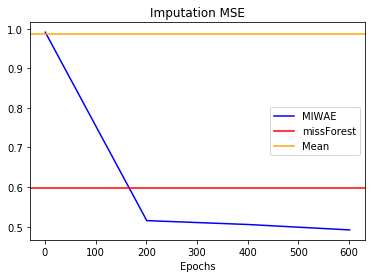

In [25]:
plt.plot(range(1,n_epochs,200),mse_train,color="blue")
plt.axhline(y=mse(xhat_mf,xfull,mask),  linestyle='-',color="red")
plt.axhline(y=mse(xhat_mean,xfull,mask),  linestyle='-',color="orange")
plt.legend(["MIWAE","missForest","Mean"])
plt.title("Imputation MSE")
plt.xlabel("Epochs")
plt.show()